In [1]:
import sys
sys.version 

'2.7.14 |Anaconda custom (64-bit)| (default, Oct 16 2017, 17:29:19) \n[GCC 7.2.0]'

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import random
%matplotlib inline
import tensorflow as tf
import shutil
import tensorflow.contrib.learn as tflearn
import tensorflow.contrib.layers as tflayers
from tensorflow.contrib.learn.python.learn import learn_runner
import tensorflow.contrib.metrics as metrics
import tensorflow.contrib.rnn as rnn

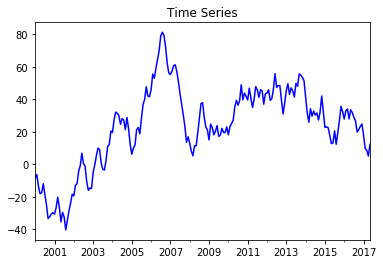

2000-01-31    -8.538682
2000-02-29    -6.290528
2000-03-31   -13.340956
2000-04-30   -18.079908
2000-05-31   -17.562679
2000-06-30   -11.939755
2000-07-31   -18.453244
2000-08-31   -24.876622
2000-09-30   -33.369224
2000-10-31   -32.265476
Freq: M, dtype: float64

In [9]:
random.seed(11)
rng=pd.date_range(start='2000',periods=209,freq='M')
ts=pd.Series(np.random.uniform(-10,10,size=len(rng)),rng).cumsum()
ts.plot(c='b',title='Time Series')
plt.show()
ts.head(10)

In [14]:
TS=np.array(ts)
num_periods=20
f_horizon=1

x_data=TS[:(len(TS)-(len(TS)% num_periods))]
x_batches=x_data.reshape(-1,20,1)

y_data=TS[:(len(TS)-(len(TS)% num_periods))+f_horizon]
y_batches=x_data.reshape(-1,20,1)


print(len(x_batches))
print(x_batches.shape)
print(x_batches[0:2])

print(y_batches[0:1])
print(y_batches.shape)


10
(10, 20, 1)
[[[ -8.53868173]
  [ -6.2905278 ]
  [-13.34095618]
  [-18.07990846]
  [-17.56267862]
  [-11.93975496]
  [-18.45324395]
  [-24.87662246]
  [-33.36922391]
  [-32.26547558]
  [-30.65334455]
  [-29.73750697]
  [-30.69694321]
  [-26.70063514]
  [-20.21427116]
  [-26.39923118]
  [-35.42405433]
  [-29.58041508]
  [-32.42534992]
  [-40.35899584]]

 [[-34.46128523]
  [-28.48290126]
  [-23.85122224]
  [-18.3889666 ]
  [-19.4290627 ]
  [-12.91720555]
  [-11.93002826]
  [ -4.21801538]
  [ -0.78275321]
  [  6.88092949]
  [  0.46963444]
  [ -1.12992455]
  [-10.65428091]
  [-15.963316  ]
  [-14.52585465]
  [-14.84969779]
  [ -5.03582224]
  [ -0.46433692]
  [  5.24124373]
  [  9.97748594]]]
[[[ -8.53868173]
  [ -6.2905278 ]
  [-13.34095618]
  [-18.07990846]
  [-17.56267862]
  [-11.93975496]
  [-18.45324395]
  [-24.87662246]
  [-33.36922391]
  [-32.26547558]
  [-30.65334455]
  [-29.73750697]
  [-30.69694321]
  [-26.70063514]
  [-20.21427116]
  [-26.39923118]
  [-35.42405433]
  [-29.58041

In [16]:
def test_data(series,forecast,num_periods):
    test_x_setup=TS[-(num_periods+forecast):]
    testX=test_x_setup[:num_periods].reshape(-1,20,1)
    testY=TS[-(num_periods):].reshape(-1,20,1)
    return testX,testY

X_test,Y_test=test_data(TS,f_horizon,num_periods)
print(X_test.shape)
print(X_test)


(1, 20, 1)
[[[ 19.61885151]
  [ 26.92704368]
  [ 35.67678508]
  [ 32.27036789]
  [ 27.86451411]
  [ 33.01849804]
  [ 34.03108161]
  [ 27.94730687]
  [ 33.58855658]
  [ 31.86036959]
  [ 28.90581794]
  [ 26.82080703]
  [ 19.91819459]
  [ 21.29355124]
  [ 23.43169686]
  [ 24.84974393]
  [ 17.92958968]
  [  9.79505519]
  [  8.62036727]
  [  5.12128956]]]


In [17]:
tf.reset_default_graph()

num_periods=20
inputs=1
hidden=100
output=1

X=tf.placeholder(tf.float32,[None,num_periods,inputs])
y=tf.placeholder(tf.float32,[None,num_periods,output])

basic_cell=tf.contrib.rnn.BasicRNNCell(num_units=hidden,activation=tf.nn.relu)
rnn_output,states=tf.nn.dynamic_rnn(basic_cell,X,dtype=tf.float32)

learning_rate=0.001

stacked_rnn_output=tf.reshape(rnn_output,[-1,hidden])
stacked_outputs=tf.layers.dense(stacked_rnn_output,output)
output=tf.reshape(stacked_outputs,[-1,num_periods,output])

loss=tf.reduce_sum(tf.square(output-y))
optimizer=tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op=optimizer.minimize(loss)

init=tf.global_variables_initializer()

In [22]:
epochs=1000

with tf.Session() as sess:
    init.run()
    for ep in range(epochs):
        sess.run(training_op,feed_dict={X:x_batches,y:y_batches})
        
        if ep % 100 == 0:
            mse=loss.eval(feed_dict={X:x_batches,y:y_batches})
            print(ep,"tMSE:",mse)
            
    y_pred=sess.run(output,feed_dict={X:X_test})
    print(y_pred)

(0, 'tMSE:', 318436.62)
(100, 'tMSE:', 7232.0898)
(200, 'tMSE:', 3222.97)
(300, 'tMSE:', 959.58221)
(400, 'tMSE:', 220.54887)
(500, 'tMSE:', 57.029701)
(600, 'tMSE:', 15.283213)
(700, 'tMSE:', 9.1660423)
(800, 'tMSE:', 5.3009539)
(900, 'tMSE:', 4.1996484)
[[[ 20.05586815]
  [ 27.18766022]
  [ 35.7847023 ]
  [ 31.80798531]
  [ 27.41452789]
  [ 33.28255081]
  [ 34.15419006]
  [ 27.67232895]
  [ 33.7325325 ]
  [ 31.64939499]
  [ 29.00442123]
  [ 26.74398041]
  [ 19.9406395 ]
  [ 21.20890999]
  [ 23.39597511]
  [ 24.75804901]
  [ 17.97585297]
  [  9.72507954]
  [  8.64535522]
  [  5.05455446]]]


In [ ]:
plt.title("Foracast vs Actual",fontsize=14)
plt.plt(pd.Series(np.ravel(Y_test)),"bo",markersize=10,label="Actual")

plt.plot(pd.Series(np.ravel(y_pred)),"r",markersize=10label="Forecast")
plt.legend(loc='upper left')
plt.x